In [18]:
import os, json, cv2, random
import matplotlib.pyplot as plt
import numpy as np

from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

In [21]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3600 # 3768 total images, half as many iterations with a batch size of 2
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # small for now, probably should be 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = "../Treework/detectron_output/"
cfg.MODEL.DEVICE='cpu'
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0054999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

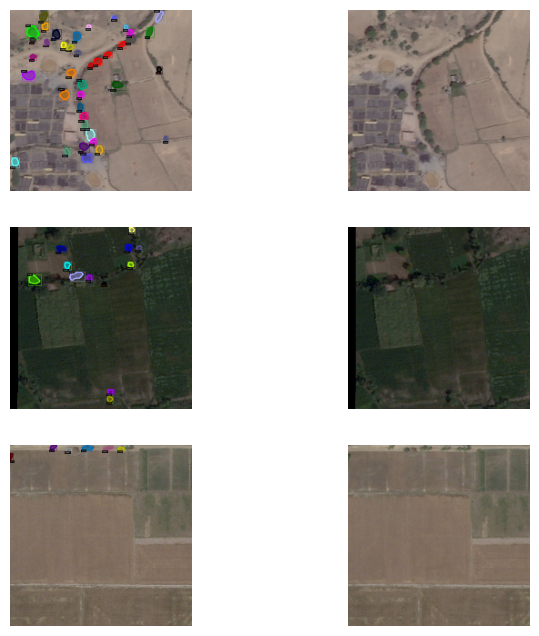

In [23]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 3
# cali_no = 8
# root = f'./NUTMGS/relabeled_tifs/cali_{cali_no}/'
# karn_no = 2
root = f'./cvat_uploads/rajasthan_extra/'
for i, d in enumerate(random.sample(os.listdir(root), rows)):    
    im = cv2.imread(os.path.join(root, d))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("test"), 
                   scale=0.5, 
                   font_size_scale=0
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    figure.add_subplot(rows, cols, 2*i+1)
    plt.axis("off")
    plt.imshow(out.get_image())
    
    figure.add_subplot(rows, cols, 2*i+2)
    plt.axis("off")
    plt.imshow(im[:, :, ::-1])

    instances = outputs["instances"].to("cpu")

In [24]:
images = []
instances = {}

for i, d in enumerate(os.listdir(root)):    
    try:
        im = cv2.imread(os.path.join(root, d))
        images.append({
            'id': i,
            'width': im.shape[1],
            'height': im.shape[0],
            'file_name': d
        })
        
        outputs = predictor(im)
        instances[i] = outputs["instances"].to("cpu")
    except Exception as e:
        print(e) 

In [25]:
import json
import numpy as np
from pycocotools import mask as maskUtils

coco_predictions = []

ann_id = 0
for instance in instances:
    inst = instances[instance]
    for i in range(len(inst)):
        bbox = inst.pred_boxes[i].tensor.numpy().tolist()[0]
        category_id = int(inst.pred_classes[i].item())+1
        score = float(inst.scores[i].item())

        annotation = {
            "id": ann_id,
            "image_id": instance,
            "category_id": category_id,
            "bbox": [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]], # Convert to [x, y, width, height]
            "iscrowd": 0,
        }
        ann_id += 1

        if inst.has("pred_masks"):
            mask = inst.pred_masks[i].numpy()
            # Convert boolean mask to RLE format (COCO standard)
            rle = maskUtils.encode(np.asfortranarray(mask))
            rle['counts'] = rle['counts'].decode('utf-8') # Ensure counts are string
            annotation["segmentation"] = rle

        coco_predictions.append(annotation)

In [ ]:
print(coco_predictions)

In [27]:
categories = [
    {"id":1,"name":"Kejri Tree","supercategory":""},
    {"id":2,"name":"Low Quality","supercategory":""}
]

coco_output = {
    "images": images,
    "annotations": coco_predictions,
    "categories": categories,
}

# Save to a JSON file
with open(f"predictions/rajasthan_extra.json", "w") as f:
    json.dump(coco_output, f)